In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
df = pd.read_csv('/Users/baptistecarbillet/Documents/MachineLearning1/smoking_driking_dataset_Ver01.csv')
df.drop('DRK_YN', axis=1, inplace=True)
#Male get one hot encoding
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

#Normalise df
#normalization
df.iloc[:,:-1]=  (df.iloc[:,:-1] - df.iloc[:,:-1].mean()) / (df.iloc[:,:-1].std())

random_state = 75
df_1 = df[df['SMK_stat_type_cd'] == 1.0].sample(5000,random_state=random_state)
df_2 = df[df['SMK_stat_type_cd'] == 2.0].sample(5000,random_state=random_state)
df_3 = df[df['SMK_stat_type_cd'] == 3.0].sample(5000,random_state=random_state)

X_1,y_1 = np.array(df_1.drop('SMK_stat_type_cd',axis=1)),np.array(df_1['SMK_stat_type_cd'])
X_2,y_2 = np.array(df_2.drop('SMK_stat_type_cd',axis=1)),np.array(df_2['SMK_stat_type_cd'])
X_3,y_3 = np.array(df_3.drop('SMK_stat_type_cd',axis=1)),np.array(df_3['SMK_stat_type_cd'])

from sklearn.model_selection import train_test_split

random_state = 75 #Paris

X_train_1,X_test_1,y_train_1,y_test_1 = train_test_split(X_1,y_1,test_size=0.2,random_state=random_state)
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X_2,y_2,test_size=0.2,random_state=random_state)
X_train_3,X_test_3,y_train_3,y_test_3 = train_test_split(X_3,y_3,test_size=0.2,random_state=random_state)

X_train = np.concatenate((X_train_1,X_train_2,X_train_3))
y_train = np.concatenate((y_train_1,y_train_2,y_train_3))

X_test = np.concatenate((X_test_1,X_test_2,X_test_3))
y_test = np.concatenate((y_test_1,y_test_2,y_test_3))

#We shuffle the data
from sklearn.utils import shuffle
X_train,y_train = shuffle(X_train,y_train,random_state=random_state)
X_test,y_test = shuffle(X_test,y_test,random_state=random_state)

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada = AdaBoostClassifier(estimator= DecisionTreeClassifier(max_depth=1,splitter='best') ,n_estimators=70,random_state=random_state)

from sklearn.model_selection import KFold, cross_validate
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True,random_state=random_state)

model = ada
scoring=('accuracy')

cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)

for i in range(n_splits):
    print('Fold',i+1)
    print('Train accuracy:',cv_results['train_score'][i])
    print('Test accuracy:',cv_results['test_score'][i])
    




Fold 1
Train accuracy: 0.6469791666666667
Test accuracy: 0.6241666666666666
Fold 2
Train accuracy: 0.6458333333333334
Test accuracy: 0.6341666666666667
Fold 3
Train accuracy: 0.6396875
Test accuracy: 0.6416666666666667
Fold 4
Train accuracy: 0.6464583333333334
Test accuracy: 0.6354166666666666
Fold 5
Train accuracy: 0.6396875
Test accuracy: 0.63875


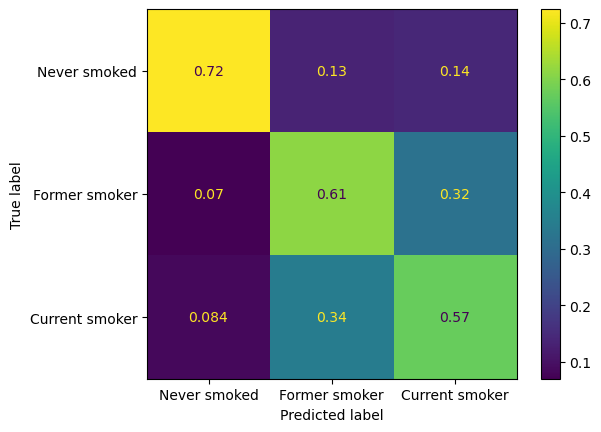

In [5]:
from sklearn.metrics import confusion_matrix
#fit model from cross validation
model.fit(X_train,y_train)
#predict
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test,y_pred,normalize='true')
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'])
disp.plot()

In [45]:
train_acc = []
test_acc = []

for n_estimators in np.linspace(1,200,51):
    model = AdaBoostClassifier(estimator= DecisionTreeClassifier(max_depth=1,splitter='best') ,n_estimators=int(n_estimators),random_state=random_state)
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)
    train_acc.append(np.mean(cv_results['train_score']))
    test_acc.append(np.mean(cv_results['test_score']))
    



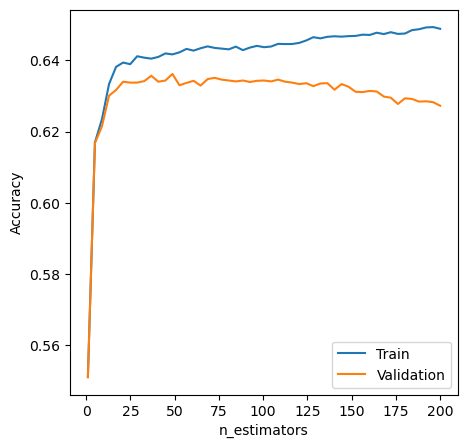

In [49]:
plt.figure(figsize=(5,5))
plt.plot(np.linspace(1,200,51),train_acc,label='Train')
plt.plot(np.linspace(1,200,51),test_acc,label='Validation')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
## Best number of estimators, based on the validation curve
n_estimators = np.linspace(1,200,51)[np.argmax(test_acc)]
print('Best number of estimators:',n_estimators)
print('Best test accuracy:',np.max(test_acc))


Best number of estimators: 1.0
Best test accuracy: 0.6348333333333332


## Grid search

In [48]:
from sklearn.model_selection import GridSearchCV
boosing_param = {'n_estimators':[50,100,200,300,400,500,1000,3000],
                'base_estimator':[DecisionTreeClassifier(max_depth=i,splitter='best',random_state=random_state) for i in range(1,4)] + [DecisionTreeClassifier(max_depth=i,splitter='random',random_state= random_state) for i in range(1,4)],
                'learning_rate':np.logspace(-3,0,4)}

grid = GridSearchCV(AdaBoostClassifier(random_state=random_state),param_grid=boosing_param,cv=4,scoring=scoring,return_train_score=True,n_jobs=-1,verbose=10)


grid.fit(X_train,y_train)

Fitting 4 folds for each of 192 candidates, totalling 768 fits
[CV 1/4; 2/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=100
[CV 1/4; 3/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=200
[CV 2/4; 1/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=50
[CV 1/4; 1/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=50
[CV 3/4; 2/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=100
[CV 2/4; 2/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=100
[CV 4/4; 2/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=100
[CV 4/4; 1/192] START base_estimator

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `e

[CV 3/4; 1/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.549, test=0.558) total time=   0.7s
[CV 4/4; 1/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.553, test=0.546) total time=   0.7s
[CV 2/4; 1/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.549, test=0.557) total time=   0.8s
[CV 1/4; 1/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.554, test=0.543) total time=   0.7s
[CV 3/4; 3/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=200
[CV 4/4; 3/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=200
[CV 1/4; 4/192] START base

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 2/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.554, test=0.543) total time=   1.3s
[CV 2/4; 2/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.549, test=0.557) total time=   1.3s
[CV 3/4; 4/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=300
[CV 4/4; 2/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.553, test=0.546) total time=   1.2s
[CV 3/4; 2/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.549, test=0.558) total time=   1.3s
[CV 4/4; 4/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=300
[CV 1/4; 5/192] START 

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 3/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.554, test=0.543) total time=   2.5s
[CV 3/4; 5/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=400
[CV 2/4; 3/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.549, test=0.557) total time=   2.5s
[CV 4/4; 5/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 3/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.553, test=0.546) total time=   2.4s
[CV 1/4; 6/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=500
[CV 3/4; 3/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.549, test=0.558) total time=   2.5s
[CV 2/4; 6/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 4/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.549, test=0.557) total time=   3.7s
[CV 3/4; 6/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=500
[CV 1/4; 4/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.554, test=0.543) total time=   3.7s
[CV 4/4; 6/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 4/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.549, test=0.558) total time=   3.7s
[CV 1/4; 7/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=1000
[CV 4/4; 4/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.553, test=0.546) total time=   3.8s
[CV 2/4; 7/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 5/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.549, test=0.557) total time=   4.8s
[CV 3/4; 7/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=1000
[CV 1/4; 5/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.554, test=0.543) total time=   5.0s
[CV 4/4; 7/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 5/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.549, test=0.558) total time=   5.1s
[CV 1/4; 8/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 5/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.553, test=0.546) total time=   5.3s
[CV 2/4; 8/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 6/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.549, test=0.557) total time=   6.3s
[CV 3/4; 8/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=3000
[CV 1/4; 6/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.554, test=0.543) total time=   6.6s
[CV 4/4; 8/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 6/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.553, test=0.546) total time=   6.3s
[CV 1/4; 9/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=50
[CV 3/4; 6/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.549, test=0.558) total time=   6.4s
[CV 2/4; 9/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 9/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.549, test=0.557) total time=   0.5s
[CV 3/4; 9/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=50
[CV 1/4; 9/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.554, test=0.543) total time=   0.6s
[CV 4/4; 9/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 9/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.549, test=0.558) total time=   0.6s
[CV 1/4; 10/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=100
[CV 4/4; 9/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.553, test=0.546) total time=   0.6s
[CV 2/4; 10/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 10/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.554, test=0.543) total time=   1.5s
[CV 3/4; 10/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=100
[CV 2/4; 10/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.549, test=0.557) total time=   1.5s
[CV 4/4; 10/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 10/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.549, test=0.558) total time=   1.2s
[CV 1/4; 11/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=200
[CV 4/4; 10/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.553, test=0.546) total time=   1.3s
[CV 2/4; 11/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 11/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.598, test=0.590) total time=   3.0s
[CV 3/4; 11/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=200
[CV 2/4; 11/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.619, test=0.618) total time=   3.0s
[CV 4/4; 11/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 7/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.554, test=0.543) total time=  13.5s
[CV 1/4; 12/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 7/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.549, test=0.557) total time=  13.5s
[CV 2/4; 12/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 7/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.549, test=0.558) total time=  13.4s
[CV 3/4; 12/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=300
[CV 4/4; 7/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.553, test=0.546) total time=  13.3s
[CV 4/4; 12/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 11/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.602, test=0.622) total time=   2.5s
[CV 1/4; 13/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=400
[CV 4/4; 11/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.611, test=0.595) total time=   2.5s
[CV 2/4; 13/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 12/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.624, test=0.612) total time=   3.4s
[CV 3/4; 13/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=400
[CV 2/4; 12/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.623, test=0.622) total time=   3.3s
[CV 4/4; 13/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 12/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.624, test=0.634) total time=   3.1s
[CV 1/4; 14/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=500
[CV 4/4; 12/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.623, test=0.614) total time=   3.2s
[CV 2/4; 14/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 13/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.628, test=0.615) total time=   4.0s
[CV 3/4; 14/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=500
[CV 2/4; 13/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.625, test=0.627) total time=   4.1s
[CV 4/4; 14/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 13/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.625, test=0.633) total time=   4.2s
[CV 1/4; 15/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 13/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.630, test=0.622) total time=   4.3s
[CV 2/4; 15/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 14/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.629, test=0.620) total time=   5.2s
[CV 3/4; 15/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=1000
[CV 2/4; 14/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.627, test=0.630) total time=   5.2s
[CV 4/4; 15/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 14/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.626, test=0.633) total time=   5.1s
[CV 1/4; 16/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=3000
[CV 4/4; 14/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.632, test=0.626) total time=   5.1s
[CV 2/4; 16/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 15/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.637, test=0.625) total time=  10.2s
[CV 3/4; 16/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 15/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.636, test=0.637) total time=  10.3s
[CV 4/4; 16/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 15/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.633, test=0.643) total time=  10.4s
[CV 1/4; 17/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 15/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.639, test=0.633) total time=  10.6s
[CV 2/4; 17/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 17/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.630, test=0.621) total time=   0.5s
[CV 3/4; 17/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 17/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.628, test=0.629) total time=   0.5s
[CV 4/4; 17/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 17/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.625, test=0.631) total time=   0.6s
[CV 1/4; 18/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 17/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.631, test=0.627) total time=   0.6s
[CV 2/4; 18/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 18/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.638, test=0.626) total time=   1.1s
[CV 3/4; 18/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 18/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.637, test=0.633) total time=   1.0s
[CV 4/4; 18/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 8/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.624, test=0.612) total time=  34.0s
[CV 1/4; 19/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=200
[CV 3/4; 18/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.632, test=0.643) total time=   1.1s


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 19/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=200
[CV 2/4; 8/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.625, test=0.622) total time=  34.0s
[CV 3/4; 19/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=200
[CV 4/4; 18/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.637, test=0.634) total time=   1.1s
[CV 4/4; 19/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 8/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.624, test=0.614) total time=  33.6s
[CV 1/4; 20/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=300
[CV 3/4; 8/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.624, test=0.634) total time=  33.8s
[CV 2/4; 20/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 19/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.645, test=0.629) total time=   2.2s
[CV 3/4; 20/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=300
[CV 2/4; 19/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.644, test=0.640) total time=   2.2s
[CV 4/4; 20/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 19/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.644, test=0.645) total time=   2.3s
[CV 1/4; 21/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=400
[CV 4/4; 19/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.642, test=0.640) total time=   2.3s
[CV 2/4; 21/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 20/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.647, test=0.629) total time=   3.2s
[CV 3/4; 21/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=400
[CV 2/4; 20/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.649, test=0.643) total time=   3.2s
[CV 4/4; 21/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 20/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.646, test=0.648) total time=   3.1s
[CV 1/4; 22/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 20/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.645, test=0.643) total time=   3.1s
[CV 2/4; 22/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 21/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.649, test=0.628) total time=   4.1s
[CV 3/4; 22/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=500
[CV 2/4; 21/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.647, test=0.641) total time=   4.1s
[CV 4/4; 22/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 21/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.648, test=0.647) total time=   4.1s
[CV 1/4; 23/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=1000
[CV 4/4; 21/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.646, test=0.647) total time=   4.1s
[CV 2/4; 23/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 22/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.652, test=0.630) total time=   5.2s
[CV 3/4; 23/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 22/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.646, test=0.642) total time=   5.2s
[CV 4/4; 23/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 22/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.647, test=0.646) total time=   5.0s
[CV 3/4; 22/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.649, test=0.645) total time=   5.1s
[CV 1/4; 24/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=3000
[CV 2/4; 24/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 23/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.655, test=0.626) total time=  10.0s
[CV 3/4; 24/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=3000
[CV 1/4; 16/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.645, test=0.629) total time=  31.2s
[CV 4/4; 24/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=3000
[CV 2/4; 23/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.650, test=0.643) total time=  10.0s
[CV 1/4; 25/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 16/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.649, test=0.642) total time=  31.5s
[CV 2/4; 25/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 25/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.646, test=0.618) total time=   0.5s
[CV 3/4; 25/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 25/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.644, test=0.630) total time=   0.5s
[CV 4/4; 25/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 25/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.641, test=0.640) total time=   0.5s
[CV 1/4; 26/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 23/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.651, test=0.647) total time=   9.9s
[CV 2/4; 26/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=100
[CV 4/4; 25/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.643, test=0.635) total time=   0.5s
[CV 3/4; 26/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 23/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.650, test=0.642) total time=   9.9s
[CV 4/4; 26/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 26/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.650, test=0.615) total time=   1.0s
[CV 1/4; 27/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 26/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.645, test=0.631) total time=   1.0s
[CV 2/4; 27/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=200
[CV 3/4; 26/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.645, test=0.647) total time=   1.0s
[CV 3/4; 27/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 26/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.643, test=0.631) total time=   1.0s
[CV 4/4; 27/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 27/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.653, test=0.605) total time=   2.1s
[CV 1/4; 28/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 27/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.647, test=0.627) total time=   2.0s
[CV 2/4; 28/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=300
[CV 3/4; 27/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.649, test=0.639) total time=   2.0s
[CV 3/4; 28/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 27/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.649, test=0.629) total time=   2.0s
[CV 4/4; 28/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 16/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.646, test=0.648) total time=  31.1s
[CV 1/4; 29/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=400
[CV 4/4; 16/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.644, test=0.643) total time=  30.9s
[CV 2/4; 29/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 28/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.654, test=0.605) total time=   3.0s
[CV 3/4; 29/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=400
[CV 2/4; 28/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.650, test=0.629) total time=   3.0s
[CV 4/4; 29/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 28/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.646, test=0.635) total time=   3.0s
[CV 1/4; 30/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 28/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.652, test=0.627) total time=   3.0s
[CV 2/4; 30/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 29/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.653, test=0.603) total time=   4.0s
[CV 3/4; 30/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=500
[CV 2/4; 29/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.651, test=0.631) total time=   3.9s
[CV 4/4; 30/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 29/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.650, test=0.629) total time=   4.0s
[CV 1/4; 31/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=1000
[CV 4/4; 29/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.653, test=0.626) total time=   4.0s
[CV 2/4; 31/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 30/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.654, test=0.604) total time=   5.0s
[CV 3/4; 31/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 30/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.653, test=0.629) total time=   5.1s
[CV 4/4; 31/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 30/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.650, test=0.628) total time=   5.0s
[CV 1/4; 32/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=3000
[CV 4/4; 30/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.652, test=0.623) total time=   5.1s
[CV 2/4; 32/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 31/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.660, test=0.605) total time=  10.1s
[CV 3/4; 32/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 31/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.658, test=0.623) total time=  10.1s
[CV 4/4; 32/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 31/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.657, test=0.620) total time=  10.1s
[CV 1/4; 33/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 31/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.655, test=0.614) total time=  10.1s
[CV 2/4; 33/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=50
[CV 1/4; 24/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.659, test=0.617) total time=  30.2s
[CV 3/4; 33/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 24/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.653, test=0.634) total time=  30.4s
[CV 4/4; 33/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 33/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.615, test=0.613) total time=   0.8s
[CV 1/4; 34/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 33/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.620, test=0.616) total time=   0.9s
[CV 3/4; 33/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.618, test=0.621) total time=   0.8s
[CV 2/4; 34/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=100
[CV 3/4; 34/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 33/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.616, test=0.611) total time=   0.8s
[CV 4/4; 34/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 34/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.615, test=0.613) total time=   1.7s
[CV 1/4; 35/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 34/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.620, test=0.616) total time=   1.7s
[CV 2/4; 35/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=200
[CV 3/4; 34/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.618, test=0.621) total time=   1.7s
[CV 3/4; 35/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 34/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.616, test=0.611) total time=   1.7s
[CV 4/4; 35/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=200
[CV 1/4; 35/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.615, test=0.613) total time=   3.5s
[CV 1/4; 36/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 35/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.620, test=0.616) total time=   3.5s
[CV 2/4; 36/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=300
[CV 3/4; 35/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.618, test=0.621) total time=   3.5s
[CV 3/4; 36/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=300
[CV 4/4; 35/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.616, test=0.611) total time=   3.5s
[CV 4/4; 36/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 24/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.656, test=0.637) total time=  30.4s
[CV 1/4; 37/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=400
[CV 3/4; 24/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.653, test=0.645) total time=  30.5s
[CV 2/4; 37/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 36/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.615, test=0.613) total time=   7.6s
[CV 3/4; 37/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 36/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.620, test=0.616) total time=   7.8s
[CV 4/4; 37/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=400
[CV 3/4; 36/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.618, test=0.621) total time=   7.8s
[CV 1/4; 38/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 36/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.616, test=0.611) total time=   8.0s
[CV 2/4; 38/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 37/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.620, test=0.616) total time=  12.4s
[CV 3/4; 38/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=500
[CV 1/4; 37/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.615, test=0.613) total time=  12.5s
[CV 4/4; 38/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 37/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.618, test=0.621) total time=  12.2s
[CV 1/4; 39/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 37/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.616, test=0.611) total time=  12.2s
[CV 2/4; 39/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 38/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.622, test=0.622) total time=  15.2s
[CV 3/4; 39/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 38/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.620, test=0.616) total time=  15.3s
[CV 4/4; 39/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 38/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.618, test=0.621) total time=  15.2s
[CV 1/4; 40/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=3000
[CV 4/4; 38/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.623, test=0.617) total time=  15.3s
[CV 2/4; 40/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 32/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.661, test=0.607) total time=  42.2s
[CV 3/4; 40/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=3000
[CV 1/4; 32/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.667, test=0.592) total time=  42.2s
[CV 4/4; 40/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 32/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.663, test=0.602) total time=  46.7s
[CV 1/4; 41/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 32/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.668, test=0.597) total time=  46.9s
[CV 2/4; 41/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 41/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.622, test=0.622) total time=   1.5s
[CV 3/4; 41/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 41/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.620, test=0.616) total time=   1.6s
[CV 4/4; 41/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 41/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.618, test=0.621) total time=   1.5s
[CV 1/4; 42/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 41/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.623, test=0.617) total time=   1.6s
[CV 2/4; 42/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 42/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.625, test=0.622) total time=   3.1s
[CV 3/4; 42/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 42/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.623, test=0.618) total time=   3.0s
[CV 4/4; 42/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 42/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.618, test=0.621) total time=   3.1s
[CV 1/4; 43/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 42/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.623, test=0.617) total time=   3.2s
[CV 1/4; 39/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.625, test=0.622) total time=  30.9s
[CV 2/4; 43/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=200
[CV 3/4; 43/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 39/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.623, test=0.618) total time=  30.7s
[CV 4/4; 43/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 39/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.618, test=0.621) total time=  30.7s
[CV 1/4; 44/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 39/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.623, test=0.617) total time=  30.8s
[CV 2/4; 44/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 43/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.630, test=0.630) total time=   6.2s
[CV 3/4; 44/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 43/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.629, test=0.628) total time=   6.1s
[CV 4/4; 44/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=300
[CV 3/4; 43/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.625, test=0.636) total time=   6.1s
[CV 1/4; 45/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 43/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.631, test=0.623) total time=   6.3s
[CV 2/4; 45/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 44/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.632, test=0.626) total time=   9.3s
[CV 3/4; 45/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 44/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.633, test=0.630) total time=   9.3s
[CV 4/4; 45/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 44/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.631, test=0.640) total time=   9.4s
[CV 1/4; 46/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=500
[CV 4/4; 44/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.636, test=0.627) total time=   9.2s
[CV 2/4; 46/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 45/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.634, test=0.630) total time=  12.5s
[CV 3/4; 46/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 45/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.639, test=0.636) total time=  12.5s
[CV 4/4; 46/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 45/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.636, test=0.639) total time=  12.3s
[CV 1/4; 47/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 45/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.638, test=0.629) total time=  12.5s
[CV 2/4; 47/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 46/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.641, test=0.635) total time=  15.4s
[CV 3/4; 47/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=1000
[CV 1/4; 46/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.638, test=0.629) total time=  15.6s
[CV 4/4; 47/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 46/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.637, test=0.641) total time=  15.5s
[CV 1/4; 48/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 46/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.640, test=0.632) total time=  15.6s
[CV 2/4; 48/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 47/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.653, test=0.629) total time=  31.2s
[CV 3/4; 48/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 47/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.647, test=0.639) total time=  31.5s
[CV 4/4; 48/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 47/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.647, test=0.645) total time=  31.2s
[CV 1/4; 49/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 47/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.650, test=0.643) total time=  31.5s
[CV 2/4; 49/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 49/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.639, test=0.632) total time=   1.6s
[CV 3/4; 49/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 49/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.643, test=0.635) total time=   1.5s
[CV 4/4; 49/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 49/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.639, test=0.643) total time=   1.6s
[CV 1/4; 50/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 49/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.641, test=0.634) total time=   1.6s
[CV 2/4; 50/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 50/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.652, test=0.635) total time=   3.1s
[CV 3/4; 50/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 50/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.648, test=0.636) total time=   3.1s
[CV 4/4; 50/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 50/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.649, test=0.648) total time=   3.2s
[CV 1/4; 51/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 50/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.648, test=0.640) total time=   3.1s
[CV 2/4; 51/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 40/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.634, test=0.630) total time= 1.6min
[CV 3/4; 51/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=200
[CV 1/4; 40/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.631, test=0.626) total time= 1.6min
[CV 4/4; 51/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 40/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.631, test=0.640) total time= 1.6min
[CV 1/4; 52/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 40/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.636, test=0.628) total time= 1.6min
[CV 2/4; 52/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 51/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.662, test=0.630) total time=   6.2s
[CV 3/4; 52/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 51/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.658, test=0.639) total time=   6.2s
[CV 4/4; 52/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 51/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.654, test=0.648) total time=   6.2s
[CV 1/4; 53/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=400
[CV 4/4; 51/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.659, test=0.642) total time=   6.2s
[CV 2/4; 53/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 52/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.668, test=0.626) total time=   9.3s
[CV 3/4; 53/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 52/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.666, test=0.641) total time=   9.2s
[CV 4/4; 53/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 52/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.663, test=0.647) total time=   9.2s
[CV 1/4; 54/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 52/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.666, test=0.642) total time=   9.3s
[CV 2/4; 54/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 53/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.671, test=0.626) total time=  12.4s
[CV 3/4; 54/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=500
[CV 2/4; 53/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.670, test=0.636) total time=  12.3s
[CV 4/4; 54/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 53/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.664, test=0.647) total time=  12.2s
[CV 1/4; 55/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 53/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.668, test=0.636) total time=  12.4s
[CV 2/4; 55/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 54/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.675, test=0.625) total time=  15.5s
[CV 3/4; 55/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 54/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.674, test=0.637) total time=  15.5s
[CV 4/4; 55/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 54/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.669, test=0.642) total time=  15.3s
[CV 1/4; 56/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=3000
[CV 4/4; 54/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.672, test=0.636) total time=  15.2s
[CV 2/4; 56/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 55/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.692, test=0.619) total time=  30.8s
[CV 3/4; 56/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 55/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.689, test=0.628) total time=  31.1s
[CV 4/4; 56/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 48/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.671, test=0.628) total time= 1.6min
[CV 1/4; 57/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 48/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.662, test=0.641) total time= 1.6min
[CV 2/4; 57/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 57/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.653, test=0.604) total time=   1.8s
[CV 3/4; 57/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 57/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.653, test=0.617) total time=   1.6s
[CV 4/4; 57/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 57/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.646, test=0.628) total time=   1.7s
[CV 1/4; 58/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 57/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.647, test=0.624) total time=   1.6s
[CV 2/4; 58/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 55/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.685, test=0.634) total time=  31.6s
[CV 3/4; 58/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 58/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.662, test=0.603) total time=   3.1s
[CV 4/4; 58/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=100
[CV 4/4; 55/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.691, test=0.632) total time=  31.9s
[CV 1/4; 59/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 58/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.666, test=0.616) total time=   3.1s
[CV 2/4; 59/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 58/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.654, test=0.626) total time=   3.1s
[CV 3/4; 59/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 58/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.662, test=0.614) total time=   3.1s
[CV 4/4; 59/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 59/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.687, test=0.587) total time=   6.1s
[CV 1/4; 60/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 59/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.677, test=0.608) total time=   6.2s
[CV 2/4; 60/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 59/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.676, test=0.606) total time=   6.2s
[CV 3/4; 60/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 59/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.682, test=0.598) total time=   5.9s
[CV 4/4; 60/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 60/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.709, test=0.570) total time=   9.1s
[CV 1/4; 61/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=400
[CV 3/4; 48/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.661, test=0.642) total time= 1.6min
[CV 2/4; 61/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 60/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.696, test=0.609) total time=   8.9s
[CV 3/4; 61/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 48/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.666, test=0.642) total time= 1.6min
[CV 4/4; 61/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 60/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.691, test=0.601) total time=   9.2s
[CV 1/4; 62/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 60/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.698, test=0.594) total time=   9.1s
[CV 2/4; 62/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 61/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.707, test=0.596) total time=  12.0s
[CV 3/4; 62/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=500
[CV 1/4; 61/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.720, test=0.580) total time=  12.3s
[CV 2/4; 61/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.706, test=0.583) total time=  12.3s
[CV 4/4; 62/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=500
[CV 1/4; 63/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 61/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.711, test=0.584) total time=  12.2s
[CV 2/4; 63/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 62/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.733, test=0.577) total time=  15.4s
[CV 3/4; 63/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=1000
[CV 2/4; 62/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.722, test=0.577) total time=  15.4s
[CV 4/4; 63/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 62/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.725, test=0.586) total time=  15.3s
[CV 1/4; 64/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=3000
[CV 3/4; 62/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.721, test=0.603) total time=  15.4s
[CV 2/4; 64/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 63/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.777, test=0.565) total time=  31.6s
[CV 3/4; 64/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 63/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.776, test=0.571) total time=  31.6s
[CV 4/4; 64/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 63/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.786, test=0.573) total time=  31.4s
[CV 1/4; 65/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 63/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.777, test=0.587) total time=  31.8s
[CV 2/4; 65/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=50
[CV 1/4; 56/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.734, test=0.605) total time= 1.6min
[CV 3/4; 65/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=50
[CV 2/4; 56/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.730, test=0.615) total time= 1.6min
[CV 4/4; 65/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 65/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.617, test=0.607) total time=   2.1s
[CV 1/4; 66/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 65/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.620, test=0.616) total time=   2.3s
[CV 3/4; 65/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.621, test=0.619) total time=   2.1s
[CV 2/4; 66/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=100
[CV 3/4; 66/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=100
[CV 4/4; 65/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=50;, score=(train=0.616, test=0.611) total time=   2.2s
[CV 4/4; 66/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 66/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.617, test=0.607) total time=   4.4s
[CV 1/4; 67/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 66/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.620, test=0.616) total time=   4.3s
[CV 2/4; 67/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=200
[CV 3/4; 66/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.621, test=0.619) total time=   4.4s
[CV 3/4; 67/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=200
[CV 4/4; 66/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=100;, score=(train=0.616, test=0.611) total time=   4.3s
[CV 4/4; 67/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 67/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.623, test=0.620) total time=   9.0s
[CV 1/4; 68/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=300
[CV 2/4; 67/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.620, test=0.616) total time=   8.7s
[CV 2/4; 68/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 67/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.622, test=0.618) total time=   8.8s
[CV 3/4; 68/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=300
[CV 3/4; 67/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=200;, score=(train=0.622, test=0.626) total time=   9.0s


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 68/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=300
[CV 3/4; 56/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.728, test=0.623) total time= 1.5min
[CV 1/4; 69/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 56/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.733, test=0.629) total time= 1.5min
[CV 2/4; 69/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 68/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.624, test=0.625) total time=  13.1s
[CV 3/4; 69/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=400
[CV 2/4; 68/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.620, test=0.616) total time=  13.2s
[CV 4/4; 69/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 68/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.622, test=0.622) total time=  13.1s
[CV 1/4; 70/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=500
[CV 4/4; 68/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=300;, score=(train=0.625, test=0.618) total time=  13.0s
[CV 2/4; 70/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 69/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.629, test=0.624) total time=  17.5s
[CV 3/4; 70/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 69/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.621, test=0.618) total time=  17.7s
[CV 4/4; 70/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 69/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.625, test=0.617) total time=  17.5s
[CV 1/4; 71/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=1000
[CV 3/4; 69/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=400;, score=(train=0.622, test=0.622) total time=  17.8s
[CV 2/4; 71/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 70/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.629, test=0.625) total time=  21.9s
[CV 3/4; 71/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 70/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.621, test=0.618) total time=  22.1s
[CV 4/4; 71/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 70/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.622, test=0.622) total time=  21.7s
[CV 1/4; 72/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 70/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=500;, score=(train=0.625, test=0.617) total time=  21.9s
[CV 2/4; 72/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 64/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.837, test=0.556) total time= 1.6min
[CV 1/4; 64/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.844, test=0.556) total time= 1.6min
[CV 3/4; 72/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=3000
[CV 4/4; 72/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 64/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.835, test=0.570) total time= 1.5min
[CV 1/4; 73/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 64/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.842, test=0.574) total time= 1.5min
[CV 2/4; 73/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=50
[CV 1/4; 71/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.633, test=0.629) total time=  43.3s
[CV 3/4; 73/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 71/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.628, test=0.622) total time=  43.7s
[CV 4/4; 73/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=50
[CV 1/4; 73/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.629, test=0.628) total time=   2.2s
[CV 1/4; 74/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 73/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.622, test=0.619) total time=   2.2s
[CV 2/4; 74/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 73/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.622, test=0.622) total time=   2.1s
[CV 3/4; 74/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 73/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=50;, score=(train=0.625, test=0.617) total time=   2.2s
[CV 4/4; 74/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 71/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.627, test=0.634) total time=  43.4s
[CV 1/4; 75/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 71/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=1000;, score=(train=0.629, test=0.622) total time=  43.3s
[CV 2/4; 75/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 74/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.635, test=0.629) total time=   4.3s
[CV 3/4; 75/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=200
[CV 2/4; 74/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.628, test=0.623) total time=   4.3s
[CV 4/4; 75/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 74/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.627, test=0.634) total time=   4.4s
[CV 1/4; 76/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 74/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=100;, score=(train=0.629, test=0.621) total time=   4.4s
[CV 2/4; 76/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 75/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.638, test=0.631) total time=   8.8s
[CV 3/4; 76/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=300
[CV 2/4; 75/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.638, test=0.633) total time=   8.6s
[CV 4/4; 76/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 75/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.632, test=0.639) total time=   8.8s
[CV 1/4; 77/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 75/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=200;, score=(train=0.637, test=0.625) total time=   8.8s
[CV 2/4; 77/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 76/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.647, test=0.632) total time=  13.1s
[CV 3/4; 77/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 76/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.643, test=0.638) total time=  12.9s
[CV 4/4; 77/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 76/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.642, test=0.628) total time=  13.0s
[CV 1/4; 78/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=500
[CV 3/4; 76/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=300;, score=(train=0.638, test=0.644) total time=  13.2s
[CV 2/4; 78/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 77/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.652, test=0.630) total time=  17.1s
[CV 3/4; 78/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 77/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.649, test=0.639) total time=  17.3s
[CV 4/4; 78/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 77/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.642, test=0.646) total time=  17.4s
[CV 1/4; 79/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 77/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=400;, score=(train=0.648, test=0.631) total time=  17.4s
[CV 2/4; 79/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 78/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.653, test=0.629) total time=  21.5s
[CV 3/4; 79/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 78/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.651, test=0.641) total time=  21.7s
[CV 4/4; 79/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 78/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.647, test=0.645) total time=  21.7s
[CV 1/4; 80/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=3000
[CV 4/4; 78/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=500;, score=(train=0.653, test=0.632) total time=  21.4s
[CV 2/4; 80/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 79/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.668, test=0.632) total time=  42.7s
[CV 3/4; 80/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 79/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.668, test=0.640) total time=  42.3s
[CV 4/4; 80/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 79/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.664, test=0.642) total time=  38.1s
[CV 1/4; 81/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 79/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=1000;, score=(train=0.672, test=0.641) total time=  38.1s
[CV 2/4; 81/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 81/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.653, test=0.631) total time=   1.2s
[CV 3/4; 81/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 81/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.649, test=0.643) total time=   1.1s
[CV 4/4; 81/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 81/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.648, test=0.643) total time=   1.1s
[CV 1/4; 82/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 81/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=50;, score=(train=0.653, test=0.629) total time=   1.1s
[CV 2/4; 82/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 72/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.647, test=0.631) total time= 2.0min
[CV 3/4; 82/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=100
[CV 1/4; 82/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.667, test=0.630) total time=   2.3s
[CV 4/4; 82/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 82/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.664, test=0.639) total time=   2.2s
[CV 1/4; 83/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 72/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.643, test=0.638) total time= 2.0min
[CV 2/4; 83/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 82/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.665, test=0.644) total time=   2.2s
[CV 3/4; 83/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=200
[CV 4/4; 82/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=100;, score=(train=0.667, test=0.639) total time=   2.2s
[CV 4/4; 83/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 83/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.686, test=0.627) total time=   4.5s
[CV 1/4; 84/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 83/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.688, test=0.630) total time=   4.3s
[CV 2/4; 84/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 83/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.684, test=0.642) total time=   4.3s
[CV 3/4; 84/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=300
[CV 4/4; 83/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=200;, score=(train=0.683, test=0.637) total time=   4.3s
[CV 4/4; 84/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 72/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.642, test=0.627) total time= 1.9min
[CV 3/4; 72/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.001, n_estimators=3000;, score=(train=0.639, test=0.644) total time= 1.9min
[CV 1/4; 85/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=400
[CV 2/4; 85/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 84/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.704, test=0.622) total time=   6.3s
[CV 3/4; 85/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 84/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.704, test=0.624) total time=   6.5s
[CV 4/4; 85/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 84/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.699, test=0.643) total time=   6.4s
[CV 1/4; 86/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=500
[CV 4/4; 84/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=300;, score=(train=0.701, test=0.631) total time=   6.3s
[CV 2/4; 86/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 85/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.719, test=0.621) total time=   8.4s
[CV 3/4; 86/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=500
[CV 1/4; 85/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.718, test=0.626) total time=   8.4s
[CV 4/4; 86/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 85/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.713, test=0.637) total time=   8.2s
[CV 1/4; 87/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 85/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=400;, score=(train=0.718, test=0.628) total time=   8.6s
[CV 2/4; 87/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 86/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.728, test=0.622) total time=  10.6s
[CV 3/4; 87/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=1000
[CV 1/4; 86/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.730, test=0.622) total time=  10.8s
[CV 4/4; 87/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 86/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.722, test=0.630) total time=  10.5s
[CV 1/4; 88/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 86/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=500;, score=(train=0.731, test=0.625) total time=  10.5s
[CV 2/4; 88/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 87/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.779, test=0.611) total time=  26.1s
[CV 3/4; 88/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 80/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.704, test=0.622) total time= 1.4min
[CV 4/4; 88/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 80/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.701, test=0.633) total time= 1.4min
[CV 1/4; 89/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 87/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.774, test=0.624) total time=  26.5s
[CV 2/4; 89/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 89/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.668, test=0.590) total time=   1.3s
[CV 3/4; 89/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 89/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.674, test=0.599) total time=   1.2s
[CV 4/4; 89/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 89/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.666, test=0.606) total time=   1.2s
[CV 1/4; 90/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 89/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=50;, score=(train=0.669, test=0.613) total time=   1.3s
[CV 2/4; 90/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 87/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.777, test=0.626) total time=  26.5s
[CV 3/4; 90/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 87/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=1000;, score=(train=0.783, test=0.622) total time=  26.9s
[CV 4/4; 90/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 90/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.701, test=0.574) total time=   2.8s
[CV 1/4; 91/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 90/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.699, test=0.589) total time=   2.8s
[CV 2/4; 91/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 90/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.696, test=0.600) total time=   2.6s
[CV 3/4; 91/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 90/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=100;, score=(train=0.707, test=0.600) total time=   2.6s
[CV 4/4; 91/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 91/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.759, test=0.570) total time=   4.8s
[CV 1/4; 92/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=300
[CV 2/4; 91/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.751, test=0.572) total time=   4.6s
[CV 2/4; 92/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 91/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.752, test=0.580) total time=   4.5s
[CV 3/4; 92/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 91/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=200;, score=(train=0.756, test=0.588) total time=   4.5s
[CV 4/4; 92/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 80/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.700, test=0.642) total time= 1.2min
[CV 1/4; 93/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 80/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.01, n_estimators=3000;, score=(train=0.704, test=0.637) total time= 1.2min
[CV 2/4; 93/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 92/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.802, test=0.566) total time=   6.8s
[CV 3/4; 93/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=400
[CV 2/4; 92/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.791, test=0.578) total time=   6.8s
[CV 4/4; 93/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 92/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.793, test=0.572) total time=   6.6s
[CV 1/4; 94/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 92/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=300;, score=(train=0.797, test=0.580) total time=   7.0s
[CV 2/4; 94/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 93/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.828, test=0.567) total time=   9.0s
[CV 3/4; 94/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 93/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.826, test=0.577) total time=   8.9s
[CV 4/4; 94/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 93/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.824, test=0.572) total time=   9.0s
[CV 1/4; 95/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=1000
[CV 4/4; 93/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=400;, score=(train=0.827, test=0.577) total time=   9.0s
[CV 2/4; 95/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 94/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.844, test=0.563) total time=  11.1s
[CV 3/4; 95/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 94/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.844, test=0.565) total time=  11.2s
[CV 4/4; 95/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 94/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.840, test=0.581) total time=  11.2s
[CV 1/4; 96/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 94/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=500;, score=(train=0.843, test=0.581) total time=  11.5s
[CV 2/4; 96/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 95/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.875, test=0.568) total time=  22.8s
[CV 3/4; 96/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 95/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.885, test=0.585) total time=  22.8s
[CV 4/4; 96/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 95/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.882, test=0.596) total time=  22.6s
[CV 1/4; 97/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 97/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.554, test=0.543) total time=   0.2s
[CV 2/4; 97/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 97/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.549, test=0.557) total time=   0.2s
[CV 3/4; 97/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 97/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.549, test=0.558) total time=   0.2s
[CV 4/4; 97/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50
[CV 2/4; 88/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.877, test=0.602) total time= 1.2min
[CV 1/4; 98/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 97/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.553, test=0.546) total time=   0.2s
[CV 2/4; 98/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100
[CV 1/4; 88/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.873, test=0.597) total time= 1.2min
[CV 3/4; 98/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 98/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.554, test=0.543) total time=   0.4s
[CV 4/4; 98/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100
[CV 4/4; 95/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=1000;, score=(train=0.876, test=0.582) total time=  23.0s
[CV 1/4; 99/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 98/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.549, test=0.557) total time=   0.4s
[CV 2/4; 99/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200
[CV 3/4; 98/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.549, test=0.558) total time=   0.4s
[CV 3/4; 99/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 98/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.553, test=0.546) total time=   0.4s
[CV 4/4; 99/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 99/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.554, test=0.543) total time=   0.7s
[CV 1/4; 100/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 99/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.549, test=0.557) total time=   0.8s
[CV 2/4; 100/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300
[CV 3/4; 99/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.549, test=0.558) total time=   0.8s
[CV 3/4; 100/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 99/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.553, test=0.546) total time=   0.9s
[CV 4/4; 100/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 88/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.873, test=0.618) total time=  56.0s
[CV 1/4; 101/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400
[CV 1/4; 100/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.554, test=0.543) total time=   1.3s
[CV 2/4; 101/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 88/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=0.1, n_estimators=3000;, score=(train=0.881, test=0.608) total time=  55.7s
[CV 3/4; 101/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400
[CV 2/4; 100/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.549, test=0.557) total time=   1.2s
[CV 4/4; 101/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400
[CV 3/4; 100/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.549, test=0.558) total time=   1.2s


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 102/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500
[CV 4/4; 100/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.553, test=0.546) total time=   1.2s
[CV 2/4; 102/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 101/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.554, test=0.543) total time=   1.1s
[CV 3/4; 102/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 101/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.549, test=0.558) total time=   1.1s
[CV 4/4; 102/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 101/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.549, test=0.557) total time=   1.6s
[CV 1/4; 103/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 101/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.553, test=0.546) total time=   1.5s
[CV 2/4; 103/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 102/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.554, test=0.543) total time=   2.0s
[CV 3/4; 103/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000
[CV 3/4; 102/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.549, test=0.558) total time=   1.4s
[CV 4/4; 103/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 102/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.549, test=0.557) total time=   1.9s
[CV 1/4; 104/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 102/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.553, test=0.546) total time=   1.4s
[CV 2/4; 104/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 103/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.553, test=0.546) total time=   2.9s
[CV 3/4; 104/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 103/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.554, test=0.543) total time=   4.2s
[CV 4/4; 104/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000
[CV 2/4; 103/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.549, test=0.557) total time=   3.9s
[CV 1/4; 105/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 105/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.554, test=0.543) total time=   0.1s
[CV 2/4; 105/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 105/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.549, test=0.557) total time=   0.2s
[CV 3/4; 105/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 105/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.549, test=0.558) total time=   0.2s
[CV 4/4; 105/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50
[CV 3/4; 103/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.549, test=0.558) total time=   4.2s
[CV 1/4; 106/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 105/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.553, test=0.546) total time=   0.2s
[CV 2/4; 106/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 106/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.554, test=0.543) total time=   0.4s
[CV 3/4; 106/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 106/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.549, test=0.557) total time=   0.4s
[CV 4/4; 106/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 106/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.549, test=0.558) total time=   0.4s
[CV 1/4; 107/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 106/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.553, test=0.546) total time=   0.4s
[CV 2/4; 107/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 107/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.629, test=0.626) total time=   0.8s
[CV 3/4; 107/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200
[CV 2/4; 107/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.624, test=0.621) total time=   0.8s


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 107/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200
[CV 3/4; 107/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.624, test=0.627) total time=   0.8s
[CV 1/4; 108/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300
[CV 4/4; 107/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.623, test=0.621) total time=   0.8s
[CV 2/4; 108/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 108/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.626, test=0.628) total time=   1.1s
[CV 1/4; 108/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.631, test=0.634) total time=   1.2s
[CV 3/4; 108/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300
[CV 4/4; 108/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 104/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.625, test=0.624) total time=   8.5s
[CV 1/4; 109/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 108/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.625, test=0.628) total time=   1.3s
[CV 2/4; 109/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400
[CV 4/4; 108/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.628, test=0.621) total time=   1.3s
[CV 3/4; 109/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 109/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.632, test=0.632) total time=   1.1s
[CV 4/4; 109/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 109/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.624, test=0.627) total time=   1.6s
[CV 1/4; 110/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500
[CV 2/4; 109/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.626, test=0.628) total time=   1.7s
[CV 2/4; 110/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 109/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.626, test=0.621) total time=   1.1s
[CV 3/4; 110/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 104/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.624, test=0.626) total time=   8.6s
[CV 4/4; 110/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 104/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.627, test=0.628) total time=  11.9s
[CV 1/4; 111/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 110/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.627, test=0.630) total time=   1.4s
[CV 2/4; 111/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 110/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.632, test=0.634) total time=   2.2s
[CV 3/4; 111/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000
[CV 4/4; 110/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.629, test=0.624) total time=   1.4s
[CV 4/4; 111/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000
[CV 2/4; 110/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.630, test=0.627) total time=   2.3s
[CV 1/4; 112/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 111/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.635, test=0.632) total time=   2.8s
[CV 2/4; 112/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 111/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.635, test=0.633) total time=   2.9s
[CV 3/4; 112/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 104/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.624, test=0.620) total time=  12.5s
[CV 4/4; 112/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 111/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.640, test=0.629) total time=   4.5s
[CV 1/4; 113/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 113/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.631, test=0.626) total time=   0.3s
[CV 2/4; 113/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 113/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.629, test=0.623) total time=   0.2s
[CV 3/4; 113/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 111/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.635, test=0.643) total time=   4.6s
[CV 4/4; 113/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50
[CV 3/4; 113/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.621, test=0.626) total time=   0.3s
[CV 1/4; 114/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 113/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.627, test=0.623) total time=   0.3s
[CV 2/4; 114/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 114/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.636, test=0.631) total time=   0.5s
[CV 3/4; 114/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 114/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.637, test=0.631) total time=   0.5s
[CV 4/4; 114/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 114/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.628, test=0.636) total time=   0.5s
[CV 1/4; 115/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 114/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.636, test=0.631) total time=   0.6s
[CV 2/4; 115/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 115/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.643, test=0.626) total time=   1.4s
[CV 3/4; 115/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 115/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.637, test=0.638) total time=   1.6s
[CV 4/4; 115/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 115/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.636, test=0.641) total time=   1.2s
[CV 1/4; 116/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 115/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.638, test=0.637) total time=   1.0s
[CV 2/4; 116/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 116/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.648, test=0.627) total time=   1.8s
[CV 3/4; 116/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 116/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.644, test=0.638) total time=   1.8s
[CV 4/4; 116/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 116/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.642, test=0.649) total time=   1.6s
[CV 1/4; 117/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 116/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.642, test=0.643) total time=   1.7s
[CV 2/4; 117/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 112/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.646, test=0.637) total time=  10.2s
[CV 3/4; 117/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 112/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.642, test=0.651) total time=  10.2s
[CV 4/4; 117/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 117/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.648, test=0.630) total time=   2.5s
[CV 1/4; 118/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500
[CV 3/4; 117/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.648, test=0.650) total time=   1.3s
[CV 2/4; 118/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 117/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.646, test=0.640) total time=   1.4s
[CV 3/4; 118/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500
[CV 2/4; 117/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.648, test=0.638) total time=   2.2s
[CV 4/4; 118/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 112/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.648, test=0.627) total time=  16.5s
[CV 1/4; 119/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 118/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.649, test=0.629) total time=   1.9s
[CV 2/4; 119/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000
[CV 2/4; 118/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.649, test=0.640) total time=   2.0s
[CV 3/4; 119/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 118/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.648, test=0.653) total time=   2.0s
[CV 4/4; 119/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 118/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.648, test=0.645) total time=   3.1s
[CV 1/4; 120/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 119/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.656, test=0.629) total time=   3.5s
[CV 2/4; 120/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 119/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.654, test=0.640) total time=   3.5s
[CV 3/4; 120/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000
[CV 3/4; 119/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.654, test=0.649) total time=   3.6s
[CV 4/4; 120/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 119/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.651, test=0.646) total time=   3.6s
[CV 1/4; 121/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 121/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.641, test=0.624) total time=   0.2s
[CV 2/4; 121/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 121/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.636, test=0.629) total time=   0.2s
[CV 3/4; 121/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 121/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.636, test=0.636) total time=   0.2s
[CV 4/4; 121/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50
[CV 4/4; 112/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.640, test=0.645) total time=  17.5s
[CV 1/4; 122/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100
[CV 4/4; 121/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.631, test=0.641) total time=   0.1s
[CV 2/4; 122/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 122/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.645, test=0.622) total time=   0.3s
[CV 3/4; 122/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100
[CV 1/4; 122/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.641, test=0.615) total time=   0.5s
[CV 4/4; 122/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 122/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.641, test=0.643) total time=   0.3s
[CV 1/4; 123/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 122/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.639, test=0.631) total time=   0.5s
[CV 2/4; 123/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 123/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.645, test=0.612) total time=   0.6s
[CV 3/4; 123/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 123/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.642, test=0.634) total time=   0.7s
[CV 4/4; 123/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 123/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.648, test=0.632) total time=   1.2s
[CV 1/4; 124/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 123/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.645, test=0.634) total time=   0.7s
[CV 2/4; 124/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 124/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.648, test=0.631) total time=   1.0s
[CV 3/4; 124/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 124/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.649, test=0.609) total time=   1.8s
[CV 4/4; 124/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 124/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.646, test=0.633) total time=   0.9s
[CV 1/4; 125/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 124/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.649, test=0.636) total time=   1.3s
[CV 2/4; 125/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 125/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.651, test=0.610) total time=   1.3s
[CV 3/4; 125/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 125/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.646, test=0.633) total time=   1.3s
[CV 4/4; 125/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 125/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.648, test=0.631) total time=   2.4s
[CV 1/4; 126/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 120/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.657, test=0.639) total time=  10.0s
[CV 2/4; 126/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500
[CV 4/4; 125/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.651, test=0.633) total time=   1.4s
[CV 3/4; 126/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500
[CV 4/4; 120/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.653, test=0.643) total time=   9.8s
[CV 4/4; 126/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='ran

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 120/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.654, test=0.641) total time=   9.8s
[CV 1/4; 127/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 96/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.920, test=0.573) total time= 1.2min
[CV 2/4; 127/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 126/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.652, test=0.611) total time=   2.4s
[CV 3/4; 127/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 126/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.652, test=0.632) total time=   2.2s
[CV 4/4; 127/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000
[CV 3/4; 126/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.649, test=0.632) total time=   2.3s
[CV 1/4; 128/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000
[CV 4/4; 126/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.651, test=0.630) total time=   2.2s
[CV 2/4; 128/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='ran

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 127/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.657, test=0.609) total time=   4.3s
[CV 3/4; 128/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 127/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.652, test=0.622) total time=   4.2s
[CV 4/4; 128/192] START base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000
[CV 3/4; 127/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.648, test=0.629) total time=   4.1s
[CV 1/4; 129/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 129/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.624, test=0.623) total time=   0.3s
[CV 2/4; 129/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 129/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.621, test=0.617) total time=   0.3s
[CV 3/4; 129/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 120/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.660, test=0.619) total time=  17.5s
[CV 4/4; 129/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50
[CV 3/4; 129/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.621, test=0.623) total time=   0.3s
[CV 1/4; 130/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 127/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.651, test=0.632) total time=   4.6s
[CV 2/4; 130/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 129/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.621, test=0.622) total time=   0.6s
[CV 3/4; 130/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100
[CV 1/4; 130/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.623, test=0.619) total time=   0.6s
[CV 4/4; 130/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 130/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.622, test=0.618) total time=   0.5s
[CV 1/4; 131/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 130/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.623, test=0.626) total time=   0.5s
[CV 2/4; 131/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200
[CV 3/4; 130/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.622, test=0.628) total time=   0.7s
[CV 3/4; 131/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 96/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.924, test=0.587) total time= 1.3min
[CV 4/4; 131/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200
[CV 1/4; 131/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.623, test=0.621) total time=   1.1s
[CV 1/4; 132/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 131/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.622, test=0.618) total time=   1.0s
[CV 2/4; 132/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 131/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.620, test=0.624) total time=   1.3s
[CV 3/4; 132/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 131/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.621, test=0.621) total time=   1.2s
[CV 4/4; 132/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300
[CV 1/4; 132/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.622, test=0.622) total time=   1.4s
[CV 1/4; 133/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 132/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.622, test=0.618) total time=   1.3s
[CV 2/4; 133/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 132/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.618, test=0.622) total time=   1.8s
[CV 3/4; 133/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 132/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.620, test=0.618) total time=   1.8s
[CV 4/4; 133/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400
[CV 1/4; 133/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.622, test=0.621) total time=   1.8s
[CV 1/4; 134/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 133/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.621, test=0.618) total time=   1.8s
[CV 2/4; 134/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 133/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.618, test=0.621) total time=   3.0s
[CV 3/4; 134/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 134/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.622, test=0.623) total time=   2.6s
[CV 4/4; 134/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 133/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.620, test=0.618) total time=   2.7s
[CV 1/4; 135/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000
[CV 1/4; 128/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000;, score=(train=0.664, test=0.601) total time=  11.9s
[CV 2/4; 135/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 134/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.622, test=0.617) total time=   2.8s
[CV 3/4; 135/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000
[CV 2/4; 128/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000;, score=(train=0.658, test=0.607) total time=  12.3s
[CV 4/4; 135/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 134/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.618, test=0.621) total time=   2.7s
[CV 1/4; 136/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000
[CV 4/4; 134/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.620, test=0.619) total time=   2.6s
[CV 2/4; 136/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 128/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000;, score=(train=0.659, test=0.613) total time=  12.4s
[CV 3/4; 136/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 128/192] END base_estimator=DecisionTreeClassifier(max_depth=1, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000;, score=(train=0.654, test=0.621) total time=  11.9s
[CV 4/4; 136/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 96/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.921, test=0.587) total time= 1.3min
[CV 1/4; 137/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 135/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.622, test=0.617) total time=   4.9s
[CV 1/4; 137/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.621, test=0.621) total time=   0.2s
[CV 2/4; 137/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50
[CV 3/4; 137/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 137/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.622, test=0.619) total time=   0.3s
[CV 4/4; 137/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50
[CV 3/4; 137/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.621, test=0.623) total time=   0.4s
[CV 1/4; 138/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 137/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.621, test=0.622) total time=   0.2s
[CV 2/4; 138/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100
[CV 4/4; 135/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.622, test=0.619) total time=   4.8s
[CV 3/4; 138/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 135/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.620, test=0.623) total time=   5.1s
[CV 4/4; 138/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100
[CV 1/4; 138/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.623, test=0.623) total time=   0.7s
[CV 1/4; 139/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 138/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.622, test=0.618) total time=   0.6s
[CV 2/4; 139/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200
[CV 3/4; 138/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.623, test=0.628) total time=   0.6s
[CV 3/4; 139/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 138/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.624, test=0.624) total time=   0.6s
[CV 4/4; 139/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 135/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.624, test=0.625) total time=   6.9s
[CV 1/4; 140/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300
[CV 1/4; 139/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.626, test=0.625) total time=   1.2s
[CV 2/4; 140/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 139/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.622, test=0.629) total time=   1.2s
[CV 3/4; 140/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300
[CV 2/4; 139/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.626, test=0.621) total time=   1.3s
[CV 4/4; 140/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 139/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.625, test=0.623) total time=   1.2s
[CV 1/4; 141/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 140/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.633, test=0.632) total time=   1.5s
[CV 2/4; 141/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400
[CV 3/4; 96/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75), learning_rate=1.0, n_estimators=3000;, score=(train=0.922, test=0.594) total time= 1.4min
[CV 3/4; 141/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400
[CV 2/4; 140/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.629, test=0.629) total time=   1.6s
[CV 4/4; 141/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_r

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 140/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.628, test=0.631) total time=   1.5s
[CV 4/4; 140/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.632, test=0.628) total time=   1.5s
[CV 2/4; 142/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500
[CV 1/4; 142/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 141/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.636, test=0.631) total time=   2.0s
[CV 3/4; 142/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 141/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.633, test=0.632) total time=   2.0s
[CV 4/4; 142/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500
[CV 3/4; 141/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.632, test=0.638) total time=   2.2s
[CV 1/4; 143/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 141/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.635, test=0.629) total time=   2.1s
[CV 2/4; 143/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 142/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.641, test=0.631) total time=   2.7s
[CV 2/4; 142/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.636, test=0.631) total time=   2.7s
[CV 3/4; 143/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000
[CV 4/4; 143/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 142/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.635, test=0.641) total time=   2.9s
[CV 1/4; 144/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 142/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.638, test=0.631) total time=   3.2s
[CV 2/4; 144/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 143/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.650, test=0.630) total time=   5.8s
[CV 3/4; 144/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000
[CV 2/4; 143/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.647, test=0.640) total time=   5.8s
[CV 4/4; 144/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 143/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.642, test=0.648) total time=   5.8s
[CV 1/4; 145/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 143/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.646, test=0.637) total time=   5.8s
[CV 2/4; 145/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50
[CV 1/4; 145/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.638, test=0.625) total time=   0.4s
[CV 3/4; 145/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 145/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.635, test=0.630) total time=   0.3s
[CV 4/4; 145/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50
[CV 3/4; 145/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.635, test=0.637) total time=   0.3s
[CV 1/4; 146/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 145/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.635, test=0.635) total time=   0.3s
[CV 2/4; 146/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 146/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.645, test=0.629) total time=   0.5s
[CV 3/4; 146/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100
[CV 2/4; 146/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.642, test=0.635) total time=   0.5s
[CV 4/4; 146/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 136/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.632, test=0.629) total time=  16.4s
[CV 1/4; 147/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 146/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.641, test=0.643) total time=   0.6s
[CV 2/4; 136/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.629, test=0.624) total time=  16.9s
[CV 2/4; 147/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200
[CV 3/4; 147/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200
[CV 4/4; 146/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.641, test=0.641) total time=   0.6s
[CV 4/4; 147/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='ra

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 136/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.629, test=0.632) total time=  16.5s
[CV 1/4; 148/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 147/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.653, test=0.627) total time=   1.2s
[CV 2/4; 148/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300
[CV 4/4; 136/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.631, test=0.626) total time=  16.7s
[CV 3/4; 148/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 147/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.649, test=0.651) total time=   1.3s
[CV 4/4; 148/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300
[CV 2/4; 147/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.652, test=0.641) total time=   1.3s
[CV 1/4; 149/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400
[CV 4/4; 147/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.652, test=0.647) total time=   1.3s
[CV 2/4; 149/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='rando

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 148/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.659, test=0.628) total time=   1.9s
[CV 3/4; 149/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 148/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.657, test=0.642) total time=   1.7s
[CV 4/4; 149/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400
[CV 3/4; 148/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.657, test=0.648) total time=   1.6s
[CV 1/4; 150/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 148/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.657, test=0.647) total time=   1.6s
[CV 2/4; 150/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 149/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.665, test=0.627) total time=   2.0s
[CV 3/4; 150/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500
[CV 2/4; 149/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.662, test=0.642) total time=   2.0s
[CV 4/4; 150/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 149/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.662, test=0.651) total time=   2.2s
[CV 1/4; 151/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 149/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.661, test=0.647) total time=   2.1s
[CV 2/4; 151/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 150/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.667, test=0.629) total time=   2.9s
[CV 2/4; 150/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.667, test=0.640) total time=   2.6s
[CV 3/4; 151/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000
[CV 4/4; 151/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 150/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.665, test=0.651) total time=   2.6s
[CV 1/4; 152/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000
[CV 4/4; 150/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.662, test=0.650) total time=   2.6s
[CV 2/4; 152/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 151/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.681, test=0.629) total time=   4.9s
[CV 3/4; 152/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 151/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.681, test=0.642) total time=   5.0s
[CV 4/4; 152/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 144/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.668, test=0.626) total time=  16.6s
[CV 1/4; 153/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 153/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.652, test=0.616) total time=   0.3s
[CV 2/4; 153/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 153/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.643, test=0.623) total time=   0.3s
[CV 3/4; 153/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50
[CV 3/4; 151/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.678, test=0.639) total time=   4.9s
[CV 4/4; 153/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50
[CV 4/4; 151/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.678, test=0.648) total time=   4.9s
[CV 1/4; 154/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 153/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.645, test=0.638) total time=   0.2s
[CV 2/4; 154/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100
[CV 4/4; 153/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.647, test=0.635) total time=   0.3s
[CV 3/4; 154/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 144/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.662, test=0.641) total time=  16.6s
[CV 4/4; 154/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100
[CV 1/4; 154/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.652, test=0.614) total time=   0.5s
[CV 1/4; 155/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 154/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.650, test=0.629) total time=   0.5s
[CV 2/4; 155/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200
[CV 3/4; 154/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.652, test=0.632) total time=   0.5s
[CV 3/4; 155/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 154/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.647, test=0.620) total time=   0.5s
[CV 4/4; 155/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 155/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.664, test=0.608) total time=   1.0s
[CV 1/4; 156/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 155/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.655, test=0.617) total time=   1.0s
[CV 2/4; 156/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300
[CV 3/4; 155/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.663, test=0.628) total time=   1.0s
[CV 3/4; 156/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 155/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.660, test=0.618) total time=   1.0s
[CV 4/4; 156/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 144/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.660, test=0.649) total time=  15.9s
[CV 1/4; 157/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 156/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.674, test=0.601) total time=   1.5s
[CV 2/4; 157/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400
[CV 4/4; 144/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.659, test=0.647) total time=  16.2s
[CV 3/4; 157/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 156/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.666, test=0.606) total time=   1.5s
[CV 4/4; 157/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400
[CV 3/4; 156/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.667, test=0.623) total time=   1.5s
[CV 1/4; 158/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500
[CV 4/4; 156/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.673, test=0.615) total time=   1.4s
[CV 2/4; 158/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='rando

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 157/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.685, test=0.590) total time=   1.9s
[CV 3/4; 158/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 157/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.674, test=0.601) total time=   1.9s
[CV 4/4; 158/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500
[CV 3/4; 157/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.671, test=0.612) total time=   1.9s
[CV 1/4; 159/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 157/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.678, test=0.617) total time=   1.9s
[CV 2/4; 159/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 158/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.692, test=0.580) total time=   2.4s
[CV 3/4; 159/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000
[CV 2/4; 158/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.679, test=0.595) total time=   2.5s
[CV 4/4; 159/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 158/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.674, test=0.608) total time=   2.4s
[CV 1/4; 160/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 158/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.681, test=0.607) total time=   2.5s
[CV 2/4; 160/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 159/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.724, test=0.566) total time=   4.8s
[CV 3/4; 160/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000
[CV 2/4; 159/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.717, test=0.578) total time=   4.9s
[CV 4/4; 160/192] START base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 152/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.712, test=0.626) total time=  14.6s
[CV 1/4; 161/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 161/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.626, test=0.620) total time=   0.3s
[CV 2/4; 161/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 152/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.714, test=0.627) total time=  14.9s
[CV 3/4; 161/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50
[CV 3/4; 159/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.711, test=0.592) total time=   4.9s
[CV 4/4; 161/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50
[CV 2/4; 161/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.626, test=0.619) total time=   0.3s
[CV 1/4; 162/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 159/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.715, test=0.593) total time=   4.9s
[CV 2/4; 162/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100
[CV 3/4; 161/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.622, test=0.627) total time=   0.3s
[CV 3/4; 162/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100
[CV 4/4; 161/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=50;, score=(train=0.627, test=0.624) total time=   0.3s
[CV 4/4; 162/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 162/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.626, test=0.626) total time=   0.6s
[CV 1/4; 163/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200
[CV 2/4; 162/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.623, test=0.619) total time=   0.6s
[CV 2/4; 163/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 162/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.619, test=0.622) total time=   0.6s
[CV 3/4; 163/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200
[CV 4/4; 162/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=100;, score=(train=0.624, test=0.619) total time=   0.6s
[CV 4/4; 163/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 163/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.624, test=0.624) total time=   1.2s
[CV 1/4; 164/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300
[CV 2/4; 163/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.623, test=0.618) total time=   1.2s
[CV 2/4; 164/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 163/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.620, test=0.623) total time=   1.2s
[CV 3/4; 164/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300
[CV 4/4; 163/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=200;, score=(train=0.624, test=0.619) total time=   1.2s
[CV 4/4; 164/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 152/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.708, test=0.632) total time=  14.6s
[CV 1/4; 165/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 152/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.710, test=0.633) total time=  14.7s
[CV 2/4; 165/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 164/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.626, test=0.627) total time=   1.8s
[CV 3/4; 165/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 164/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.623, test=0.618) total time=   1.9s
[CV 4/4; 165/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400
[CV 3/4; 164/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.619, test=0.623) total time=   1.9s
[CV 1/4; 166/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500
[CV 4/4; 164/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=300;, score=(train=0.623, test=0.621) total time=   1.9s
[CV 2/4; 166/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, split

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 165/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.625, test=0.625) total time=   2.7s
[CV 3/4; 166/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 165/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.624, test=0.618) total time=   2.7s
[CV 4/4; 166/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 165/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.620, test=0.625) total time=   2.7s
[CV 1/4; 167/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 165/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=400;, score=(train=0.624, test=0.618) total time=   2.6s
[CV 2/4; 167/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 166/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.626, test=0.625) total time=   3.2s
[CV 3/4; 167/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000
[CV 2/4; 166/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.623, test=0.618) total time=   3.2s
[CV 4/4; 167/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 166/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.620, test=0.623) total time=   3.1s
[CV 1/4; 168/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 166/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=500;, score=(train=0.624, test=0.618) total time=   3.1s
[CV 2/4; 168/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 160/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000;, score=(train=0.793, test=0.570) total time=  15.6s
[CV 3/4; 168/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000
[CV 2/4; 160/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000;, score=(train=0.788, test=0.560) total time=  15.3s
[CV 4/4; 168/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 167/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.627, test=0.626) total time=   5.9s
[CV 1/4; 169/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50
[CV 2/4; 167/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.625, test=0.623) total time=   5.9s
[CV 2/4; 169/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 169/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.627, test=0.622) total time=   0.3s
[CV 3/4; 169/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 169/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.627, test=0.618) total time=   0.3s
[CV 4/4; 169/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50
[CV 3/4; 169/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.622, test=0.627) total time=   0.3s
[CV 1/4; 170/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 167/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.624, test=0.627) total time=   5.8s
[CV 2/4; 170/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100
[CV 4/4; 169/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=50;, score=(train=0.627, test=0.624) total time=   0.3s
[CV 3/4; 170/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100
[CV 4/4; 167/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=1000;, score=(train=0.627, test=0.623) total time=   5.9s


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 170/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100
[CV 1/4; 170/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.628, test=0.627) total time=   0.6s
[CV 1/4; 171/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 170/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.626, test=0.622) total time=   0.7s
[CV 2/4; 171/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200
[CV 3/4; 170/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.622, test=0.626) total time=   0.7s
[CV 3/4; 171/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200
[CV 4/4; 170/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=100;, score=(train=0.627, test=0.621) total time=   0.7s
[CV 4/4; 171/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 171/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.633, test=0.631) total time=   1.3s
[CV 1/4; 172/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300
[CV 3/4; 160/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000;, score=(train=0.791, test=0.576) total time=  15.4s
[CV 2/4; 172/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300
[CV 2/4; 171/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.629, test=0.626) total time=   1.3s
[CV 3/4; 171/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='ra

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 171/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=200;, score=(train=0.631, test=0.625) total time=   1.3s
[CV 1/4; 173/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 160/192] END base_estimator=DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000;, score=(train=0.791, test=0.571) total time=  15.8s
[CV 2/4; 173/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 172/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.639, test=0.630) total time=   2.0s
[CV 3/4; 173/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400
[CV 2/4; 172/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.635, test=0.634) total time=   2.0s
[CV 4/4; 173/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400
[CV 3/4; 172/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.635, test=0.636) total time=   1.9s
[CV 1/4; 174/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 172/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=300;, score=(train=0.638, test=0.631) total time=   2.0s
[CV 2/4; 174/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 173/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.646, test=0.631) total time=   2.8s
[CV 3/4; 174/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 173/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.641, test=0.634) total time=   2.8s
[CV 4/4; 174/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 173/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.640, test=0.641) total time=   2.8s
[CV 1/4; 175/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 173/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=400;, score=(train=0.645, test=0.630) total time=   3.0s
[CV 2/4; 175/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 174/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.649, test=0.627) total time=   3.5s
[CV 3/4; 175/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000
[CV 2/4; 174/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.644, test=0.638) total time=   3.4s
[CV 4/4; 175/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 174/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.644, test=0.645) total time=   3.2s
[CV 1/4; 176/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 174/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=500;, score=(train=0.649, test=0.632) total time=   3.1s
[CV 2/4; 176/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 175/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.666, test=0.628) total time=   5.9s
[CV 3/4; 176/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 175/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.660, test=0.638) total time=   6.0s
[CV 4/4; 176/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 175/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.658, test=0.654) total time=   5.9s
[CV 1/4; 177/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50
[CV 4/4; 175/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=1000;, score=(train=0.661, test=0.645) total time=   6.1s


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 177/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50
[CV 1/4; 177/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.647, test=0.628) total time=   0.3s
[CV 3/4; 177/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 177/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.640, test=0.634) total time=   0.3s
[CV 4/4; 177/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50
[CV 3/4; 177/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.639, test=0.641) total time=   0.3s
[CV 1/4; 178/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 177/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=50;, score=(train=0.644, test=0.634) total time=   0.3s
[CV 2/4; 178/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100
[CV 1/4; 168/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.640, test=0.630) total time=  18.6s
[CV 3/4; 178/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 178/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.659, test=0.629) total time=   0.5s
[CV 4/4; 178/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 178/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.655, test=0.635) total time=   0.6s
[CV 1/4; 179/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200
[CV 2/4; 168/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.636, test=0.632) total time=  18.7s
[CV 3/4; 178/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.653, test=0.641) total time=   0.6s
[CV 3/4; 179/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200
[CV 2/4; 179/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='ra

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 178/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=100;, score=(train=0.655, test=0.639) total time=   0.6s
[CV 4/4; 179/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 179/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.674, test=0.622) total time=   1.2s
[CV 1/4; 180/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300
[CV 2/4; 179/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.672, test=0.633) total time=   1.2s
[CV 2/4; 180/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300
[CV 3/4; 179/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.671, test=0.644) total time=   1.1s
[CV 3/4; 180/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='rando

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 179/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=200;, score=(train=0.672, test=0.638) total time=   1.2s
[CV 4/4; 180/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 180/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.689, test=0.617) total time=   1.8s
[CV 1/4; 181/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400
[CV 2/4; 180/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.683, test=0.632) total time=   1.7s
[CV 2/4; 181/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400
[CV 3/4; 180/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.683, test=0.642) total time=   1.7s
[CV 3/4; 181/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='rando

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 168/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.635, test=0.638) total time=  18.8s
[CV 4/4; 181/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400
[CV 4/4; 168/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.001, n_estimators=3000;, score=(train=0.637, test=0.633) total time=  18.7s
[CV 1/4; 182/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500
[CV 4/4; 180/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=300;, score=(train=0.684, test=0.634) total time=   1.7s
[CV 2/4; 182/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter=

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 181/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.698, test=0.619) total time=   2.4s
[CV 3/4; 182/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500
[CV 2/4; 181/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.697, test=0.630) total time=   2.3s
[CV 3/4; 181/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.696, test=0.643) total time=   2.3s
[CV 1/4; 183/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000
[CV 4/4; 182/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='rand

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 181/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=400;, score=(train=0.693, test=0.628) total time=   2.3s
[CV 2/4; 183/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 182/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.706, test=0.619) total time=   2.9s
[CV 3/4; 183/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000
[CV 2/4; 182/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.705, test=0.625) total time=   2.9s
[CV 4/4; 183/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 182/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.704, test=0.639) total time=   2.9s
[CV 1/4; 184/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000
[CV 4/4; 182/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=500;, score=(train=0.703, test=0.627) total time=   2.9s
[CV 2/4; 184/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 176/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.703, test=0.630) total time=  17.5s
[CV 3/4; 184/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000
[CV 1/4; 183/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.747, test=0.616) total time=   5.9s
[CV 4/4; 184/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 183/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.738, test=0.620) total time=   5.8s
[CV 1/4; 185/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 176/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.699, test=0.641) total time=  17.6s
[CV 2/4; 185/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50
[CV 1/4; 185/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.661, test=0.603) total time=   0.3s
[CV 3/4; 185/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 185/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.658, test=0.617) total time=   0.3s
[CV 4/4; 185/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50
[CV 3/4; 185/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.656, test=0.625) total time=   0.3s
[CV 1/4; 186/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100
[CV 3/4; 183/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.738, test=0.636) total time=   5.8s
[CV 2/4; 186/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 185/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=50;, score=(train=0.654, test=0.624) total time=   0.3s
[CV 3/4; 186/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100
[CV 4/4; 183/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=1000;, score=(train=0.735, test=0.628) total time=   5.9s
[CV 4/4; 186/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 186/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.674, test=0.587) total time=   0.6s
[CV 1/4; 187/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200
[CV 2/4; 186/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.669, test=0.599) total time=   0.6s
[CV 2/4; 187/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200
[CV 4/4; 186/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=100;, score=(train=0.677, test=0.611) total time=   0.6s
[CV 3/4; 187/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='rando

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 187/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.701, test=0.576) total time=   1.1s
[CV 1/4; 188/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300
[CV 2/4; 187/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.706, test=0.594) total time=   1.2s
[CV 2/4; 188/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300
[CV 3/4; 187/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.698, test=0.592) total time=   1.2s
[CV 3/4; 188/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='rando

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 187/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=200;, score=(train=0.700, test=0.591) total time=   1.2s
[CV 4/4; 188/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 176/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.698, test=0.644) total time=  17.5s
[CV 1/4; 189/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400
[CV 1/4; 188/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.724, test=0.564) total time=   1.8s
[CV 2/4; 189/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400
[CV 2/4; 188/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.727, test=0.582) total time=   1.8s
[CV 3/4; 189/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='ran

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 188/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=300;, score=(train=0.726, test=0.581) total time=   1.8s
[CV 1/4; 190/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 176/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.01, n_estimators=3000;, score=(train=0.696, test=0.644) total time=  17.5s
[CV 2/4; 190/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 189/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.748, test=0.565) total time=   2.3s
[CV 3/4; 190/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500
[CV 2/4; 189/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.744, test=0.580) total time=   2.3s
[CV 3/4; 189/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.739, test=0.582) total time=   2.3s
[CV 4/4; 190/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500
[CV 1/4; 191/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='rando

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/4; 189/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=400;, score=(train=0.739, test=0.579) total time=   2.3s
[CV 2/4; 191/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 190/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.764, test=0.567) total time=   2.9s
[CV 3/4; 191/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/4; 190/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.768, test=0.570) total time=   2.8s
[CV 4/4; 191/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 190/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.758, test=0.585) total time=   3.0s
[CV 1/4; 192/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000
[CV 4/4; 190/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=500;, score=(train=0.765, test=0.570) total time=   3.0s
[CV 2/4; 192/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/4; 191/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.831, test=0.566) total time=   6.0s
[CV 3/4; 192/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000
[CV 2/4; 191/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.827, test=0.563) total time=   6.1s
[CV 4/4; 192/192] START base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=3000


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/4; 191/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.818, test=0.573) total time=   5.9s
[CV 4/4; 191/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=1.0, n_estimators=1000;, score=(train=0.824, test=0.576) total time=   6.0s
[CV 2/4; 184/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.826, test=0.615) total time=  17.5s
[CV 1/4; 184/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.831, test=0.603) total time=  17.7s
[CV 4/4; 184/192] END base_estimator=DecisionTreeClassifier(max_depth=3, random_state=75, splitter='random'), learning_rate=0.1, n_estimators=3000;, score=(train=0.828, test=0.621) total time=  16.8s


/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=4, estimator=AdaBoostClassifier(random_state=75), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(max_depth=1,
                                                                   random_state=75),
                                            DecisionTreeClassifier(max_depth=2,
                                                                   random_state=75),
                                            DecisionTreeClassifier(max_depth=3,
                                                                   random_state=75),
                                            DecisionTreeClassifier(max_depth=1,
                                                                   random_state=75,
                                                                   splitter='random'),
                                            DecisionTreeClassifier(max_depth=2,
                                                                   random_state=75,
                                                                   splitter='random'),
                                            DecisionTreeClassifier(max_depth=3,
                                                                   random_state=75,
                                                                   splitter='random')],
                         'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'n_estimators': [50, 100, 200, 300, 400, 500, 1000,
                                          3000]},
             return_train_score=True, scoring='accuracy', verbose=10)

In [49]:
grid.best_params_,grid.best_score_

({'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=75, splitter='random'),
  'learning_rate': 0.1,
  'n_estimators': 500},
 0.64275)

In [35]:
model = grid.best_estimator_

In [50]:
#print train score of best model
print('Train accuracy:',grid.cv_results_['mean_train_score'][grid.best_index_])

Train accuracy: 0.6653333333333333


## Learning curve of best model

In [51]:
X_train_lc,X_val_lc,y_train_lc,y_val_lc = train_test_split(X_train,y_train,test_size=0.2,random_state=random_state)
#Select a sample of X_train, with the corresponding y_train
train_acc_lc = []
val_acc_lc = []
from sklearn.metrics import accuracy_score

for sample in np.linspace(0.01,0.99,98):
    X_train_sample,X_out_sample,y_train_sample,y_out_sample = train_test_split(X_train_lc,y_train_lc,test_size=float(1 - sample),random_state=random_state)
    
    model = AdaBoostClassifier(random_state= random_state,**grid.best_params_)
    model.fit(X_train_sample,y_train_sample)
    
    y_pred = model.predict(X_val_lc)
    #Train accuracy
    y_pred_train = model.predict(X_train_sample)
    train_acc_lc.append(accuracy_score(y_train_sample,y_pred_train))
    
    #Validation accuracy
    val_acc_lc.append(accuracy_score(y_val_lc,y_pred))

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `e

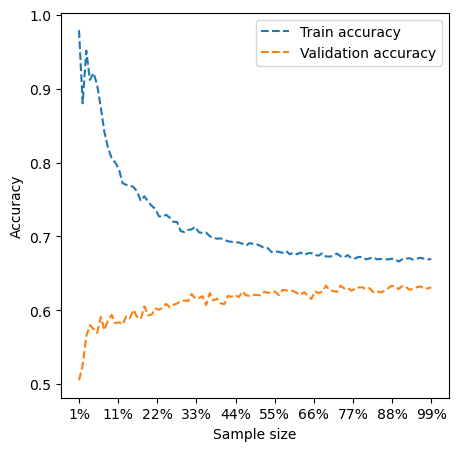

In [52]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(np.linspace(0.01,0.99,98),train_acc_lc,label='Train accuracy',linestyle='--')
##With dashed line

ax.plot(np.linspace(0.01,0.99,98),val_acc_lc,label='Validation accuracy',linestyle='--')

ax.set_xlabel('Sample size')
ax.set_ylabel('Accuracy')
#x_tick as percentage
ax.set_xticks(np.linspace(0.01,0.99,10))
ax.set_xticklabels([str(int(i*100))+'%' for i in np.linspace(0.01,0.99,10)])
ax.legend()


#confusion matrix

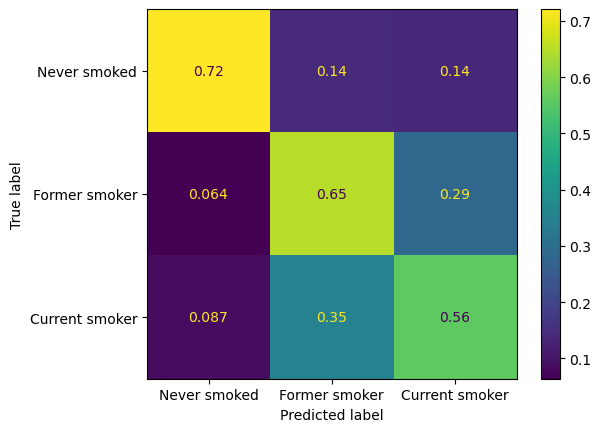

In [54]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test,y_pred,normalize='true')
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'])
disp.plot()

Confusion matrix by sex

In [56]:
#
X_test_male = X_test[X_test[:,0] > 0.5]
y_test_male = y_test[X_test[:,0] > 0.5]

X_test_female = X_test[X_test[:,0] < 0.5]
y_test_female = y_test[X_test[:,0] < 0.5]

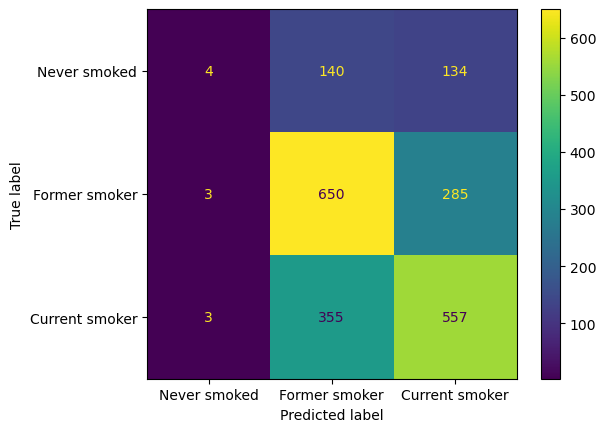

In [58]:
y_pred_male = model.predict(X_test_male)

cm = confusion_matrix(y_test_male,y_pred_male)
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()

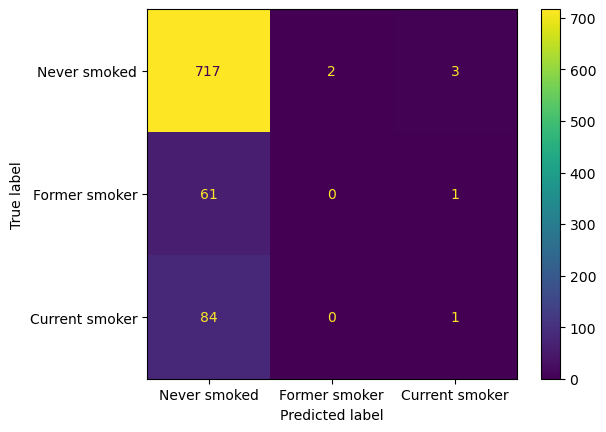

In [59]:
y_pred_female = model.predict(X_test_female)

cm = confusion_matrix(y_test_female,y_pred_female)
#plot confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'],)
disp.plot()

## Learning curve for staged prediction

In [36]:
X_train_lc,X_val_lc,y_train_lc,y_val_lc = train_test_split(X_train,y_train,test_size=0.2,random_state=random_state)

#model = AdaBoostClassifier(estimator= DecisionTreeClassifier(max_depth=1,splitter='best') ,n_estimators=100,random_state=random_state,learning_rate=1.2)
model.fit(X_train_lc,y_train_lc)

train_acc_lc = []
val_acc_lc = []


###Iterate over the staged prediction, for each prediction get the accuracy
for y_pred in model.staged_predict(X_train_lc):
    train_acc_lc.append(np.mean(y_pred == y_train_lc))
    
for y_pred in model.staged_predict(X_val_lc):
    val_acc_lc.append(np.mean(y_pred == y_val_lc))
    

/Users/baptistecarbillet/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Text(0, 0.5, 'Accuracy')

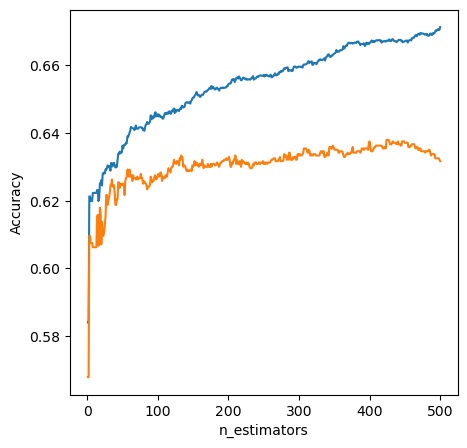

In [38]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(np.arange(1,501),train_acc_lc,label='Train')
ax.plot(np.arange(1,501),val_acc_lc,label='Validation')
ax.set_xlabel('n_estimators')
ax.set_ylabel('Accuracy')

### Depth of tree

In [21]:


train_acc = []
test_acc = []

for d in range(1,11):
    model = AdaBoostClassifier(estimator= DecisionTreeClassifier(max_depth=d,splitter='best') ,n_estimators=70,random_state=random_state)
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)
    train_acc.append(np.mean(cv_results['train_score']))
    test_acc.append(np.mean(cv_results['test_score']))

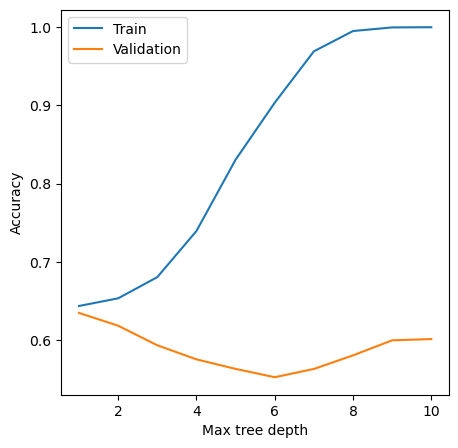

In [22]:
plt.figure(figsize=(5,5))
plt.plot([i for i in range(1,11)],train_acc,label='Train')
plt.plot([i for i in range(1,11)],test_acc,label='Validation')
plt.xlabel('Max tree depth')
plt.ylabel('Accuracy')
plt.legend()

### Learning rate

In [42]:
train_acc = []
test_acc = []

for lr in np.linspace(0.001,1,10):
    model = AdaBoostClassifier(estimator= DecisionTreeClassifier(max_depth=1,splitter='best') ,n_estimators=70,random_state=random_state,learning_rate= lr)
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True,return_estimator=True)
    train_acc.append(np.mean(cv_results['train_score']))
    test_acc.append(np.mean(cv_results['test_score']))

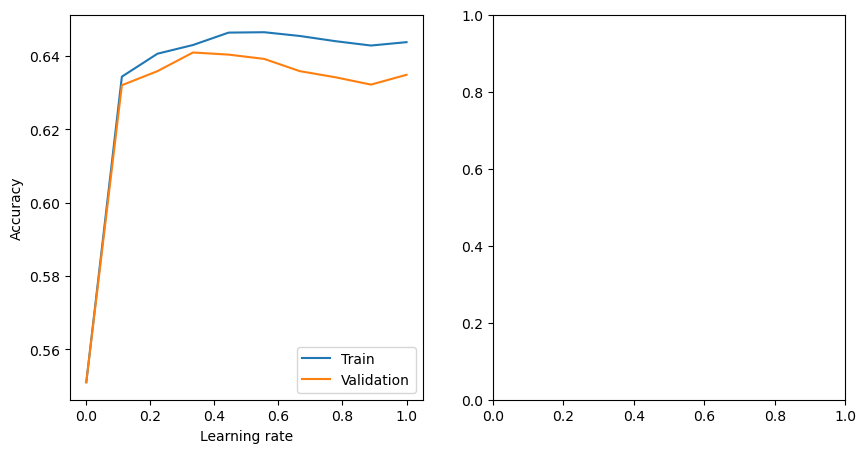

In [44]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.linspace(0.001,1,10),train_acc,label='Train')
ax[0].plot(np.linspace(0.001,1,10),test_acc,label='Validation')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

In [39]:
best_model = AdaBoostClassifier(estimator= DecisionTreeClassifier(max_depth=2,splitter='random') ,n_estimators=500,random_state=random_state,learning_rate=0.1)
best_model.fit(X_train,y_train)
#accuracy on test
from sklearn.metrics import accuracy_score
accuracy_score(best_model.predict(X_test),y_test)

0.643

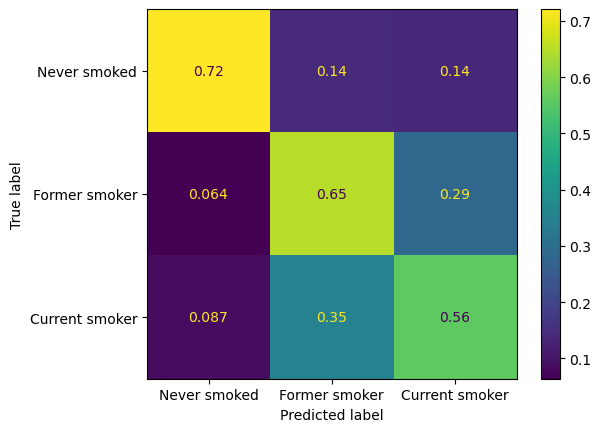

In [40]:
#Confusion matrix

from sklearn.metrics import confusion_matrix
#fit model from cross validation



cm = confusion_matrix(y_test,best_model.predict(X_test),normalize='true')
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'])
disp.plot()

## Pred by sex?

In [41]:
X_test_male = X_test[X_test[:,0] > 0.5]
y_test_male = y_test[X_test[:,0] > 0.5]

X_test_female = X_test[X_test[:,0] < 0.5]
y_test_female = y_test[X_test[:,0] < 0.5]

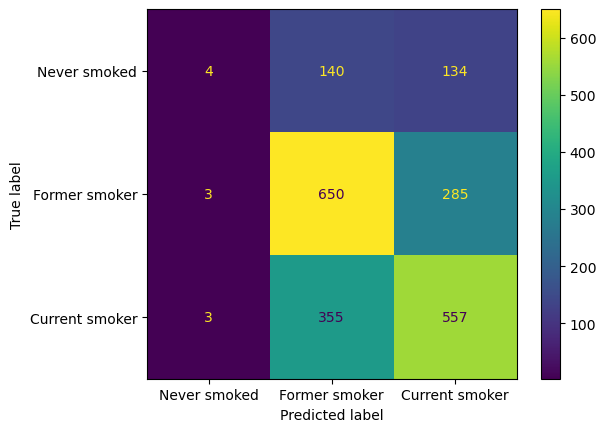

In [45]:
#male
#Confusion matrix

from sklearn.metrics import confusion_matrix
#fit model from cross validation



cm = confusion_matrix(y_test_male,best_model.predict(X_test_male))
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'])
disp.plot()

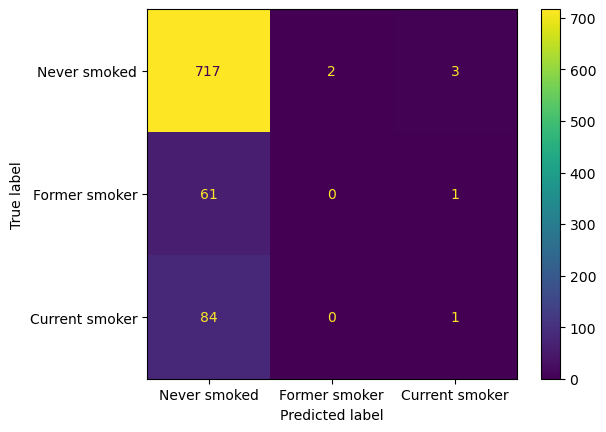

In [46]:
#female
#Confusion matrix

from sklearn.metrics import confusion_matrix
#fit model from cross validation



cm = confusion_matrix(y_test_female,best_model.predict(X_test_female))
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels= ['Never smoked','Former smoker','Current smoker'])
disp.plot()

Score on test

In [53]:
model = AdaBoostClassifier(estimator= DecisionTreeClassifier(max_depth=2,splitter='random') ,n_estimators=500,random_state=random_state,learning_rate=0.1)
model.fit(X_train,y_train)

#accuracy on test
from sklearn.metrics import accuracy_score
accuracy_score(model.predict(X_test),y_test)


0.643